# Example 1

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import gudhi as gd
from gudhi.representations.vector_methods import PersistenceImage
from sklearn.cluster import KMeans

from scipy.interpolate import PchipInterpolator
from scipy.stats import ttest_ind

from skimage import measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label as sk_label, regionprops, regionprops_table


In [2]:
plt.style.use("seaborn-v0_8")
np.random.seed(0)

SUBJECTS = ["circle", "square", "star", "triangle"]
SAMPLES_PER_CLASS = 100
FOURIER_SAMPLES = 360
FREQUENCIES = np.array([1, 2, 3, 4, 5])
N_CLUSTERS = 5
PERSISTENCE_DIRECTION = np.array([1.0, 1.0, 1.0, 1.0, 0.2], dtype=float)
PERSISTENCE_ENDPOINT = np.zeros_like(PERSISTENCE_DIRECTION)
PERSISTENCE_RESOLUTION = 50
SHAPES_ROOT = "shapes"
STAR_LABEL = SUBJECTS.index("star")

In [3]:
def convert_to_1d_polar(file_path: str, K: int = FOURIER_SAMPLES) -> np.ndarray:
    """이미지를 각도-반지름 곡선 r(θ)으로 변환한다."""
    img = plt.imread(file_path).astype(float)

    if img.ndim == 3:
        img = rgb2gray(img)
    if img.max() > 1:
        img /= 255.0

    threshold = threshold_otsu(img)
    mask = img < threshold

    lab = sk_label(mask)
    regions = regionprops(lab)
    if not regions:
        raise ValueError(f"No valid region found in {file_path!r}.")
    region = max(regions, key=lambda r: r.area)
    cy, cx = region.centroid

    contours = measure.find_contours(mask.astype(float), 0.5)
    if not contours:
        raise ValueError(f"No contour detected in {file_path!r}.")
    contour = max(contours, key=len)

    dy = contour[:, 0] - cy
    dx = contour[:, 1] - cx
    theta = np.mod(np.arctan2(dy, dx), 2 * np.pi)
    radius = np.hypot(dx, dy)

    order = np.argsort(theta)
    theta = theta[order]
    radius = radius[order]

    if len(theta) > 1:
        keep = [0]
        for idx in range(1, len(theta)):
            if theta[idx] - theta[keep[-1]] > 1e-8:
                keep.append(idx)
        theta = theta[keep]
        radius = radius[keep]

    theta_ext = np.concatenate([theta - 2 * np.pi, theta, theta + 2 * np.pi])
    radius_ext = np.concatenate([radius, radius, radius])
    interpolator = PchipInterpolator(theta_ext, radius_ext, extrapolate=False)

    theta_new = np.linspace(0, 2 * np.pi, K, endpoint=False)
    theta_query = ((theta_new - theta.min()) % (2 * np.pi)) + theta.min()
    r_theta = interpolator(theta_query)

    m = np.max(r_theta)
    if m > 0:
        r_theta = r_theta / m

    return np.clip(r_theta, 0.0, None)

In [4]:
def load_polar_dataset(subjects, root_dir, samples_per_class, K=FOURIER_SAMPLES):
    total = len(subjects) * samples_per_class
    data = np.zeros((total, K), dtype=float)
    labels = np.zeros(total, dtype=int)
    sample_ids = np.zeros(total, dtype=int)

    for subject_idx, subject in enumerate(subjects):
        for sample_idx in range(samples_per_class):
            row = subject_idx * samples_per_class + sample_idx
            file_path = os.path.join(root_dir, subject, f"{sample_idx}.png")
            data[row] = convert_to_1d_polar(file_path, K=K)
            labels[row] = subject_idx
            sample_ids[row] = sample_idx
    return data, labels, sample_ids


data, labels, sample_ids = load_polar_dataset(SUBJECTS, SHAPES_ROOT, SAMPLES_PER_CLASS)
print(f"signals: {data.shape}, labels: {labels.shape}")


signals: (400, 360), labels: (400,)


In [5]:
def compute_persistence_diagram(signal, direction, endpoint):
    max_freq = len(direction)
    norm = np.sqrt(max_freq)
    birth = (-endpoint) / (norm * direction)
    fft_coeff = np.abs(np.fft.fft(signal))[1:max_freq + 1] / signal.shape[0]
    death = (2 * np.sqrt(3) * fft_coeff - endpoint) / (norm * direction)
    return np.vstack([birth, death]).T


def build_persistence_features(signals, direction, endpoint, resolution):
    diagrams = [compute_persistence_diagram(signal, direction, endpoint) for signal in signals]
    max_value = max(diag[:, 1].max() for diag in diagrams)

    imager = PersistenceImage(
        bandwidth=0.05,
        weight=lambda x: x[1],
        resolution=[resolution, resolution],
        im_range=[0, max_value, 0, max_value],
    )

    features = np.array([imager(diagram) for diagram in diagrams])
    min_vals = features.min(axis=1, keepdims=True)
    max_vals = features.max(axis=1, keepdims=True)
    denom = np.clip(max_vals - min_vals, 1e-12, None)
    normalized = (features - min_vals) / denom
    return diagrams, normalized


diagrams, persistence_features = build_persistence_features(
    data,
    PERSISTENCE_DIRECTION,
    PERSISTENCE_ENDPOINT,
    PERSISTENCE_RESOLUTION,
)

In [6]:
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    init="random",
    n_init=100,
    max_iter=300,
    tol=1e-4,
    random_state=0,
)
cluster_labels = kmeans.fit_predict(persistence_features)


array([[  0,   0,   0,   0, 100],
       [100,   0,   0,   0,   0],
       [  0,   0,  76,  24,   0],
       [  0, 100,   0,   0,   0]])

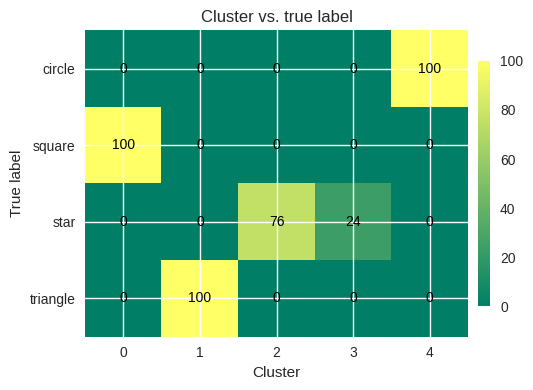

In [7]:
def plot_cluster_confusion(y_true, y_pred, subject_names):
    n_classes = len(subject_names)
    n_clusters = len(np.unique(y_pred))
    matrix = np.zeros((n_classes, n_clusters), dtype=int)

    for class_idx in range(n_classes):
        for cluster_idx in range(n_clusters):
            matrix[class_idx, cluster_idx] = np.sum((y_true == class_idx) & (y_pred == cluster_idx))

    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(matrix, cmap="summer")
    ax.set_xticks(range(n_clusters))
    ax.set_xlabel("Cluster")
    ax.set_yticks(range(n_classes))
    ax.set_yticklabels(subject_names)
    ax.set_ylabel("True label")
    ax.set_title("Cluster vs. true label")

    for i in range(n_classes):
        for j in range(n_clusters):
            ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    plt.tight_layout()
    return matrix


confusion = plot_cluster_confusion(labels, cluster_labels, SUBJECTS)
confusion

In [8]:
star_indices = np.where(labels == STAR_LABEL)[0]
star_cluster_counts = np.bincount(cluster_labels[star_indices], minlength=N_CLUSTERS)
top_clusters = np.argsort(star_cluster_counts)[-2:][::-1]

star_group_a = np.where((labels == STAR_LABEL) & (cluster_labels == top_clusters[0]))[0]
star_group_b = np.where((labels == STAR_LABEL) & (cluster_labels == top_clusters[1]))[0]

print("Top clusters for 'star':", top_clusters)
print("Group A size:", len(star_group_a))
print("Group B size:", len(star_group_b))


Top clusters for 'star': [2 3]
Group A size: 76
Group B size: 24


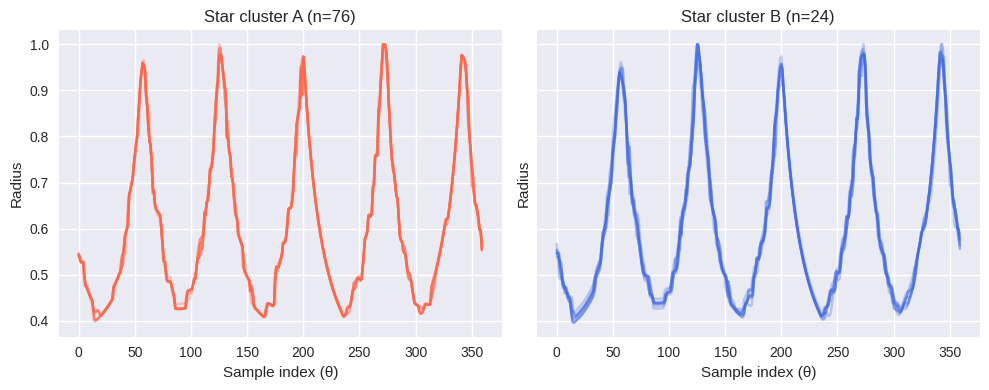

In [9]:
def plot_signal_group(ax, dataset, indices, title, color):
    if len(indices) == 0:
        ax.set_title(f"{title} (empty)")
        ax.axis("off")
        return
    subset = dataset[indices[: min(len(indices), 9)]]
    ax.plot(subset.T, color=color, alpha=0.3)
    ax.set_title(f"{title} (n={len(indices)})")
    ax.set_xlabel("Sample index (θ)")
    ax.set_ylabel("Radius")


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_signal_group(axes[0], data, star_group_a, "Star cluster A", "tomato")
plot_signal_group(axes[1], data, star_group_b, "Star cluster B", "royalblue")
plt.tight_layout()
plt.show()


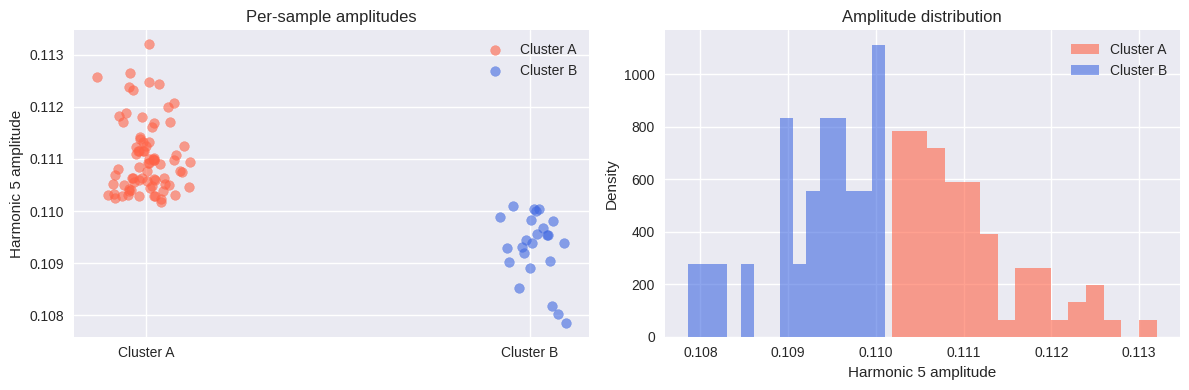

In [10]:
def harmonic_amplitude(dataset, indices, harmonic):
    if len(indices) == 0:
        return np.array([])
    coeff = np.abs(np.fft.fft(dataset[indices], axis=1))[:, harmonic]
    return coeff / dataset.shape[1]


harmonic_index = 5
amp_a = harmonic_amplitude(data, star_group_a, harmonic_index)
amp_b = harmonic_amplitude(data, star_group_b, harmonic_index)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(
    np.ones_like(amp_a) + 0.05 * np.random.randn(len(amp_a)),
    amp_a,
    color="tomato",
    alpha=0.6,
    label="Cluster A",
)
axes[0].scatter(
    2 * np.ones_like(amp_b) + 0.05 * np.random.randn(len(amp_b)),
    amp_b,
    color="royalblue",
    alpha=0.6,
    label="Cluster B",
)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(["Cluster A", "Cluster B"])
axes[0].set_ylabel(f"Harmonic {harmonic_index} amplitude")
axes[0].set_title("Per-sample amplitudes")
axes[0].legend()

axes[1].hist(amp_a, bins=15, alpha=0.6, color="tomato", density=True, label="Cluster A")
axes[1].hist(amp_b, bins=15, alpha=0.6, color="royalblue", density=True, label="Cluster B")
axes[1].set_xlabel(f"Harmonic {harmonic_index} amplitude")
axes[1].set_ylabel("Density")
axes[1].set_title("Amplitude distribution")
axes[1].legend()

plt.tight_layout()
plt.show()


In [11]:
def recolor_star_for_display(img_rgb, *, cmap_name="Set3", color_idx=0, alpha=0.9, edge=False, ax=None):
    img = img_rgb.astype(np.float32).copy()
    if img.max() > 1.0:
        img /= 255.0

    gray = rgb2gray(img)
    thr = threshold_otsu(gray)
    mask = gray < thr

    cmap = plt.colormaps[cmap_name]
    color = np.array(cmap(color_idx % cmap.N)[:3], dtype=np.float32).reshape(1, 1, 3)
    img[mask] = (1 - alpha) * img[mask] + alpha * color

    if edge and ax is not None:
        contours = measure.find_contours(mask.astype(float), 0.5)
        for cnt in contours:
            ax.plot(cnt[:, 1], cnt[:, 0], lw=1.2, color="k", alpha=0.8)

    return img


def to_rgb(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        arr = np.stack([arr] * 3, axis=-1)
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[..., :3]
    return arr


def draw_leaf(path):
    img = mpimg.imread(path)
    if img.dtype not in (np.float32, np.float64):
        img = img.astype(np.float32) / 255.0
    h, w = img.shape[:2]
    return img, (w / 2.0, h / 2.0)


def cohens_d(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    if len(x) < 2 or len(y) < 2:
        return np.nan
    sx = np.var(x, ddof=1)
    sy = np.var(y, ddof=1)
    sp = np.sqrt(((len(x) - 1) * sx + (len(y) - 1) * sy) / (len(x) + len(y) - 2))
    return (np.mean(y) - np.mean(x)) / sp if sp > 0 else np.nan


def measure_with_regionprops(img_rgb, *, spacing=None):
    gray = rgb2gray(img_rgb)
    thr  = threshold_otsu(gray)
    mask = gray < thr
    lab  = sk_label(mask)
    if lab.max() == 0:
        return None

    props = [
        "area",
        "eccentricity",
        "perimeter",
    ]

    tbl = regionprops_table(lab, intensity_image=gray, spacing=spacing, properties=props)
    dfp = pd.DataFrame(tbl)
    if len(dfp) == 0:
        return None

    row = dfp.loc[dfp["area"].idxmax()].to_dict()

    # cast scalars to float
    out = {k: (float(v) if np.isscalar(v) else v) for k, v in row.items()}

    # add circularity if perimeter > 0
    A = out.get("area", None)
    P = out.get("perimeter", None)
    if A is not None and P is not None and P > 0:
        out["circularity"] = 4 * np.pi * A / (P**2)

    return out



def summarize_and_test(df, metric, *, group_col="group", groups=("cluster_a", "cluster_b")): 
    left = df.loc[df[group_col] == groups[0], metric].dropna().values 
    right = df.loc[df[group_col] == groups[1], metric].dropna().values 
    if len(left) < 2 or len(right) < 2: 
        return pd.Series({ "left_mean": np.nan, "left_std": np.nan, 
                          "right_mean": np.nan, "right_std": np.nan, 
                          "p_value": np.nan, "cohens_d": np.nan, }) 
        
    t_stat, p_val = ttest_ind(right, left, equal_var=False) 
    
    series = pd.Series({ "left_mean": left.mean(), "left_std": left.std(ddof=1), 
                        "right_mean": right.mean(), "right_std": right.std(ddof=1), 
                        "p_value": p_val, "cohens_d": cohens_d(left, right), }) 
    
    return series

In [12]:
STAR_DIR = os.path.join(SHAPES_ROOT, "star")
star_samples_a = np.sort(sample_ids[star_group_a])
star_samples_b = np.sort(sample_ids[star_group_b])


outer = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

records = []

for ax_idx, sample in enumerate(star_samples_a):
    path = os.path.join(STAR_DIR, f"{int(sample)}.png")
    img, _ = draw_leaf(path)
    img = to_rgb(img)
    metrics = measure_with_regionprops(img)
    if metrics:
        metrics.update(group="cluster_a", sample=int(sample))
        records.append(metrics)




for ax_idx, sample in enumerate(star_samples_b):
    path = os.path.join(STAR_DIR, f"{int(sample)}.png")
    img, _ = draw_leaf(path)
    img = to_rgb(img)
    metrics = measure_with_regionprops(img)
    if metrics:
        metrics.update(group="cluster_b", sample=int(sample))
        records.append(metrics)


metrics_df = pd.DataFrame(records)

In [13]:
metrics = [c for c in metrics_df.columns if c not in ('group','idx')]
summary = pd.concat([summarize_and_test(metrics_df, m) for m in metrics], axis=1)
summary.columns = metrics
summary = summary.T

In [15]:
metrics_to_report = [
    "circularity",
    "eccentricity",
]

summary = pd.concat(
    [summarize_and_test(metrics_df, metric).rename(metric) 
     for metric in metrics_to_report],
    axis=1,
).T

summary.round(3)

,left_mean,left_std,right_mean,right_std,p_value,cohens_d
circularity,0.270,0.004,0.275,0.004,0.000,1.084
eccentricity,0.306,0.021,0.288,0.027,0.005,-0.804


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# df_feat: (이미 만든) 개별 관측치 + ['group','idx','compactness','circularity','eccentricity']
use_cols = ['circularity', 'eccentricity']
use_cols = ['circularity']

X = metrics_df[use_cols].values
y = (metrics_df['group'].values == 'cluster_b').astype(int)

scaler = StandardScaler()
Xz = scaler.fit_transform(X)


lda = LinearDiscriminantAnalysis(n_components=1)
score = lda.fit(Xz, y).decision_function(Xz)   # +면 right쪽, -면 left쪽

df_score = metrics_df[['group','sample']].copy()
df_score['score'] = score

# 각 그룹에서 '자기 그룹 쪽으로 가장 극단적인' 상위 k개 선택
k = 9
left_top_idx  = df_score[df_score.group=='cluster_a' ].sort_values('score', ascending=True ).head(k)['sample'].tolist()
right_top_idx = df_score[df_score.group=='cluster_b'].sort_values('score', ascending=False).head(k)['sample'].tolist()
print("LEFT top:", left_top_idx)
print("RIGHT top:", right_top_idx)

LEFT top: [1, 30, 2, 3, 36, 6, 5, 34, 4]
RIGHT top: [84, 88, 73, 68, 74, 83, 85, 87, 97]


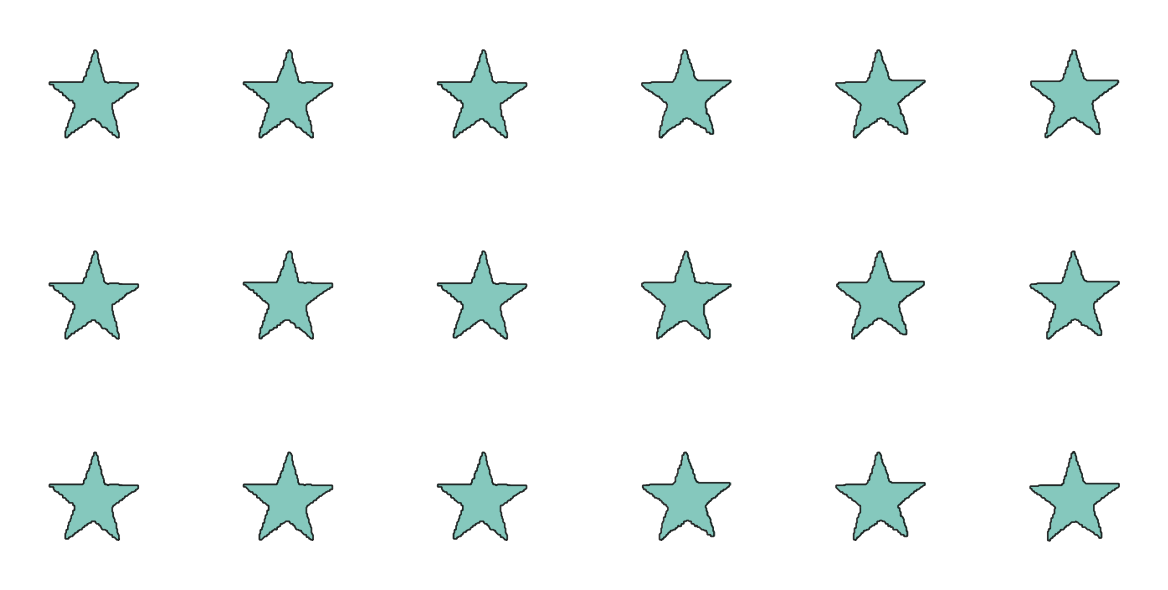

In [21]:
records = []

fig = plt.figure(figsize=(12, 6))
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# 왼쪽 3x3
gs_left = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0])
for i, num in enumerate(left_top_idx):
    ax  = fig.add_subplot(gs_left[i])
    path = os.path.join(STAR_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='left', idx=num))
        records.append(m)

# 오른쪽 3x3
gs_right = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])
for i, num in enumerate(right_top_idx):
    ax  = fig.add_subplot(gs_right[i])
    path = os.path.join(STAR_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='right', idx=num))
        records.append(m)

plt.tight_layout()
plt.show()

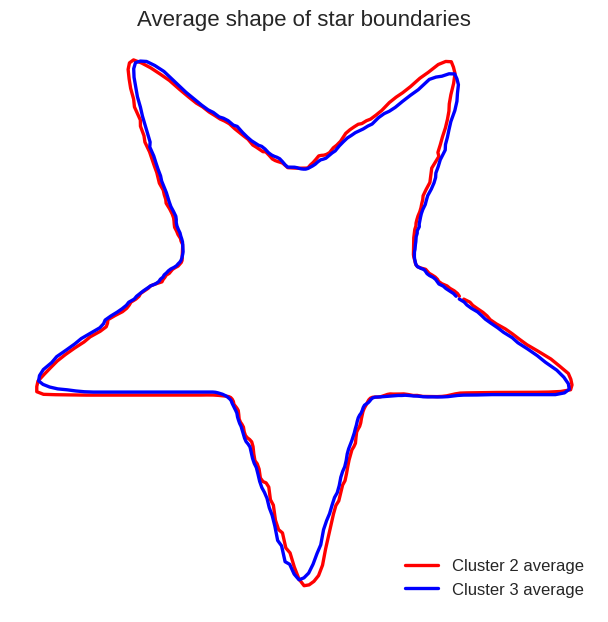

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
K = 360
USE_NORMALIZE = True
ALIGN_ORIENTATION = True   # ⬅⬅ 여기만 바꿔서 on/off
THETA = np.linspace(0, 2*np.pi, K, endpoint=False)

# --- Helpers (그대로) ---
def circ_align_to_ref(r, ref):
    R = np.fft.rfft(r); F = np.fft.rfft(ref)
    c = np.fft.irfft(R * np.conj(F), n=r.size)
    shift = int(np.argmax(c))
    return np.roll(r, shift), shift

def align_stack(R, ref):
    aligned = np.empty_like(R); shifts = []
    for i, r in enumerate(R):
        ri, s = circ_align_to_ref(r, ref)
        aligned[i] = ri; shifts.append(s)
    return aligned, np.array(shifts, dtype=int)

def rtheta_from_indices(indices, base_dir, K=K, use_normalize=USE_NORMALIZE):
    rows = []
    for num in indices:
        path = os.path.join(base_dir, f"{int(num)}.png")
        r = convert_to_1d_polar(path, K=K)  # <- your function
        r = np.asarray(r, dtype=float)
        if use_normalize:
            m = np.max(r)
            if m > 0: r = r / m
        rows.append(r)
    if not rows:
        raise ValueError("No inputs provided to rtheta_from_indices().")
    return np.vstack(rows)

# ---------- Load ----------
R_left  = rtheta_from_indices(star_samples_a,  STAR_DIR)
R_right = rtheta_from_indices(star_samples_b, STAR_DIR)


# ---------- 통계량 ----------
ra_mean = R_left.mean(axis=0);  rb_mean = R_right.mean(axis=0)
ddof_L = 1 if R_left.shape[0]  > 1 else 0
ddof_R = 1 if R_right.shape[0] > 1 else 0
ra_std  = R_left.std(axis=0,  ddof=ddof_L)
rb_std  = R_right.std(axis=0, ddof=ddof_R)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(6.3, 6.3))


ax.plot(ra_mean*np.cos(THETA), ra_mean*np.sin(THETA), color='red',  lw=2.4,
        label=f'Cluster 2 average')
ax.plot(rb_mean*np.cos(THETA), rb_mean*np.sin(THETA), color='blue', lw=2.4,
        label=f'Cluster 3 average')


ax.set_aspect('equal', adjustable='box'); ax.axis('off')
ax.set_title("Average shape of star boundaries", size = 16)
ax.legend(loc='lower right', frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
def lock_phase_matrix(R, K, target_deg=90, which='max'):
    """
    R: (n, K)  r(θ) 행렬. 각 샘플을 동일한 시프트로 회전시켜 '기준 각도'로 고정.
    target_deg: 예) 90 → 최댓값을 위(90°)로.
    which: 'max'면 최댓값 기준, 'min'이면 최솟값 기준.
    """
    k = K
    r_mean = R.mean(axis=0)
    idx = int(np.argmax(r_mean) if which=='max' else np.argmin(r_mean))
    target_idx = int(round((target_deg % 360) / 360 * k)) % k
    s = (target_idx - idx) % k
    return np.roll(R, s, axis=1), s

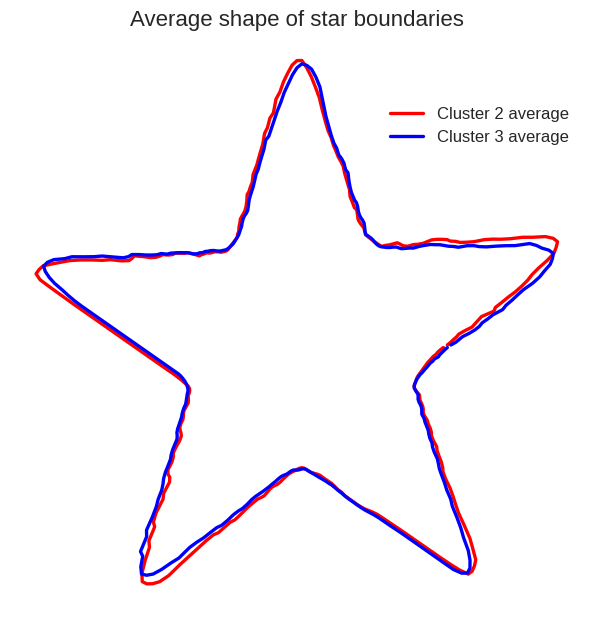

In [54]:
# ---------- Load ----------
R_left  = rtheta_from_indices(star_samples_a,  STAR_DIR)
R_right = rtheta_from_indices(star_samples_b, STAR_DIR)

# ---------- 1) 평균/표준편차(시프트 전) ----------
ra_mean = R_left.mean(axis=0);  rb_mean = R_right.mean(axis=0)
ddof_L = 1 if R_left.shape[0]  > 1 else 0
ddof_R = 1 if R_right.shape[0] > 1 else 0
ra_std  = R_left.std(axis=0,  ddof=ddof_L)
rb_std  = R_right.std(axis=0, ddof=ddof_R)

# ---------- 2) 위상 잠금: 최대 반지름을 θ=90°로 고정 ----------
K = ra_mean.size
global_mean = 0.5*(ra_mean + rb_mean)         # 두 평균의 합으로 기준 잡기
peak_idx    = int(np.argmax(global_mean))      # 최대 반지름 위치
target_idx  = int(round((90 % 360) / 360 * K)) # 90도에 해당하는 인덱스
shift       = (target_idx - peak_idx) % K

# 평균/표준편차를 동일 시프트로 회전(표준편차는 모양만 옮기면 됨)
ra_mean = np.roll(ra_mean, shift)
rb_mean = np.roll(rb_mean, shift)
ra_std  = np.roll(ra_std,  shift)
rb_std  = np.roll(rb_std,  shift)

# ---------- 3) Plot ----------
fig, ax = plt.subplots(figsize=(6.3, 6.3))

ax.plot(ra_mean*np.cos(THETA), ra_mean*np.sin(THETA),
        color='red',  lw=2.4, label='Cluster 2 average')
ax.plot(rb_mean*np.cos(THETA), rb_mean*np.sin(THETA),
        color='blue', lw=2.4, label='Cluster 3 average')

ax.set_aspect('equal', adjustable='box'); ax.axis('off')
ax.set_title("Average shape of star boundaries", fontsize=16)  # ← fontsize로 수정
ax.legend(loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()